# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

# Load Data and preprocess

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SERAJ/DATA.csv')
data

,Text,Label
0,i was born a racist and I will die a racist I ...,1
1,bitch nigga miss me with that,1
2,if you aint bout that murder game pussy nigga ...,1
3,gay niggas couldnt wait to act like bitches to...,1
4,why deos a gorilla always have a frown because...,1
...,...,...
71948,@user judd is a &amp; #homophobic #freemilo #...,1
71949,lady banned from kentucky mall. @user #jcpenn...,1
71950,@user omfg i'm offended! i'm a mailbox and i'...,1
71951,@user @user you don't have the balls to hashta...,1


In [ ]:
data.isnull().sum()

Text     0
Label    0
dtype: int64

In [ ]:
data.drop_duplicates(inplace=True)
data.shape

(71953, 2)

In [ ]:
np.unique(data.Label, return_counts=True)

(array([0, 1, 2, 3, 4]), array([16655, 10706, 12467, 19190, 12935]))

In [ ]:
classname = {0:'neither', 1:'racist', 2:'hate_speech', 3:'offensive_language', 4:'Xenophobia'}

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Text'])

In [ ]:
encoded = tokenizer.texts_to_sequences(data['Text'])

In [ ]:
encoded[100]

[1862, 5, 574, 13, 1, 173, 3, 606, 607, 5, 1, 141, 500, 2196]

In [ ]:
list_len = []
for seq in encoded:
  list_len.append(len(seq))

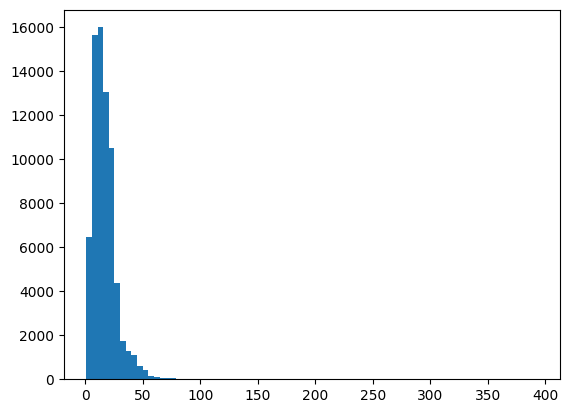

#####################################
mean of tokens 16.802259808486095
median of tokens 15.0


In [ ]:
plt.hist(list_len, bins=80)
plt.show()
print('#####################################')
print(f'mean of tokens {np.average(list_len)}')
print(f'median of tokens {np.median(list_len)}')

In [ ]:
max_len = 50

In [ ]:
X = pad_sequences(encoded, maxlen=max_len, padding='post')

In [ ]:
X.shape

(71953, 50)

In [ ]:
vocab_len = len(tokenizer.word_index) + 1
vocab_len

82121

In [ ]:
y = data['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(61160, 50)
(10793, 50)
(61160,)
(10793,)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Modeling

In [ ]:
reg_e = tf.keras.regularizers.l2(0.001)

model = Sequential()
model.add(Embedding(input_dim=vocab_len, output_dim=50, input_length=max_len, embeddings_regularizer=reg_e))
model.add(GRU(units=128, activation='tanh', recurrent_dropout=0.5, dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            4106050   
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4183751 (15.96 MB)
Trainable params: 41837

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.losses.BinaryCrossentropy()
metric = tf.metrics.BinaryAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=metric)

In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2, verbose=2)

Epoch 1/2
765/765 - 116s - loss: 0.2514 - binary_accuracy: 0.9443 - val_loss: 0.2379 - val_binary_accuracy: 0.9472 - 116s/epoch - 152ms/step
Epoch 2/2
765/765 - 116s - loss: 0.2517 - binary_accuracy: 0.9451 - val_loss: 0.2338 - val_binary_accuracy: 0.9480 - 116s/epoch - 152ms/step


# Evaluation

In [ ]:
model.evaluate(X_test, y_test)

338/338 [==============================] - 5s 16ms/step - loss: 0.2358 - binary_accuracy: 0.9465


[0.2358241230249405, 0.9465394020080566]

In [ ]:
y_prob = model.predict(X_test)

338/338 [==============================] - 5s 14ms/step


In [ ]:
y_pred = y_prob.argmax(axis=1)

In [ ]:
y_true = y_test.argmax(axis=1)

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2498
           1       0.88      0.81      0.84      1606
           2       0.82      0.79      0.81      1870
           3       0.92      0.94      0.93      2879
           4       0.90      0.88      0.89      1940

    accuracy                           0.86     10793
   macro avg       0.86      0.85      0.86     10793
weighted avg       0.86      0.86      0.86     10793



# Save model

In [ ]:
import pickle

# saving
with open('/content/drive/MyDrive/Colab Notebooks/SERAJ/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SERAJ/model.keras')

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/SERAJ/.weights.h5")
print("Saved model to disk")

Saved model to disk
